In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin,BaseEstimator


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **ICA**

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
#ICA
x = np.load('/content/drive/MyDrive/GP-Data/X_ica2.npy')
y = np.load('/content/drive/MyDrive/GP-Data/y_ica2.npy')



print(x.shape,y.shape)

(45, 32, 32) (45,)


In [ ]:
y[y==0] = 1 #Stroke
y[y==2] = 0 #Healthy

In [ ]:
# prompt: import train_test_split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=101)


In [ ]:
print(f"Training data: {X_train.shape[0] / x.shape[0] * 100:.2f}%")
#print(f"Validation data: {X_val.shape[0] / x.shape[0] * 100:.2f}%")
print(f"Test data: {X_test.shape[0] / x.shape[0] * 100:.2f}%")

Training data: 80.00%
Test data: 20.00%


In [ ]:
# Flatten the data array for ML models
X_train = X_train.reshape(X_train.shape[0], -1)
# X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
# y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)


In [ ]:
def fit_and_evaluate(X_train, y_train, X_test, y_test,model):

  model.fit(X_train, y_train)

  # Predictions on the test set
  y_pred = model.predict(X_test)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')


  # Print the results
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1-score:", f1)


  print("Classification Report (Test):\n", classification_report(y_test, y_pred))

  # Compute the confusion matrix for the test set
  cm_test = confusion_matrix(y_test, y_pred)

  # Plot the confusion matrix for the test set
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(f"Confusion Matrix {model.__class__}")
  plt.show()

  return model

<ipython-input-8-f4c83a58cea2>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy: 0.6666666666666666
Recall: 0.6666666666666666
Precision: 0.6428571428571428
F1-score: 0.6461538461538461
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.71      0.83      0.77         6

    accuracy                           0.67         9
   macro avg       0.61      0.58      0.58         9
weighted avg       0.64      0.67      0.65         9



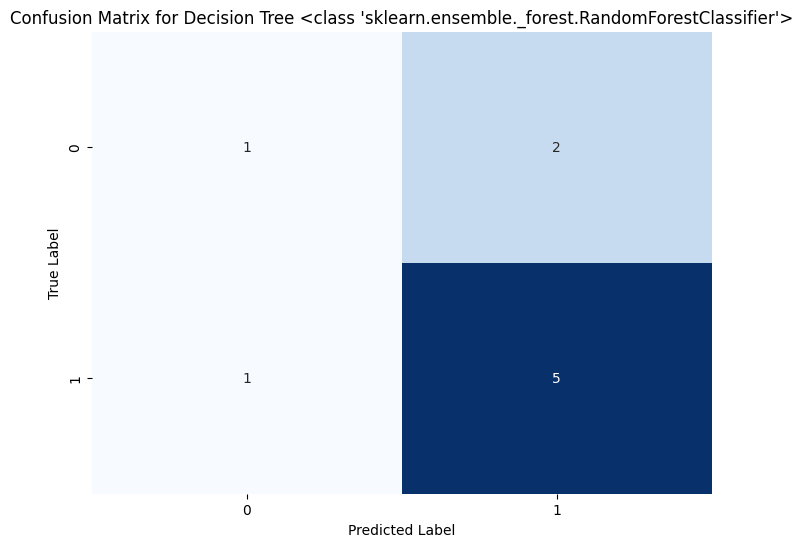

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model=fit_and_evaluate(X_train, y_train,X_test , y_test,RandomForestClassifier(n_estimators=50, max_depth=9,max_leaf_nodes=6 ))


# **PCA**

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

data_array = np.load('/content/drive/MyDrive/GP-Data/data_array_pca2.npy')
label_array = np.load('/content/drive/MyDrive/GP-Data/label_array_pca2.npy')
group_array = np.load('/content/drive/MyDrive/GP-Data/group_array_pca2.npy')

print(data_array.shape,label_array.shape,group_array.shape)

(6682, 1250, 30) (6682,) (6682,)


In [ ]:
gkf=GroupKFold()
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)


def three_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      train_features, train_label = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      train_features=scaler.fit_transform(train_features)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  # Split train_features into train and val
  for train_index, val_index in gkf.split(train_features, train_label, groups= train_groups):
      X_train, y_train =train_features[train_index],train_label[train_index]
      X_val, y_val =train_features[val_index],train_label[val_index]

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[val_index])}")

      break

  return X_train, X_val, X_test, y_train, y_val, y_test




def two_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      X_train, y_train = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      X_train=scaler.fit_transform(X_train)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  return X_train, X_test, y_train, y_test


# X_train, X_val, X_test, y_train, y_val, y_test = three_splits(data_array , label_array, group_array)

X_train, X_test, y_train, y_test = two_splits(data_array , label_array, group_array)

# convert the problem from multiclass classification to binary classification
# make haemorrhage and schaemia classes as one

y_train[y_train==0] = 1
y_train[y_train==2] = 0

# y_val[y_val==0] = 1
# y_val[y_val==2] = 0

y_test[y_test==0] = 1
y_test[y_test==2] = 0

group=[ 0  1  2  3  4  5  6  7  8  9 10 13 15 16 17 18 20 21 24 25 27 28 29 30
 31 32 33 34 36 37 39 40 41 42 43 44]
group=[11 12 14 19 22 23 26 35 38]


In [ ]:
# Reshape data for compatibility with classifiers
re_Xtrain = X_train.reshape(X_train.shape[0], -1)
# re_Xval = X_val.reshape(X_val.shape[0], -1)
re_Xtest = X_test.reshape(X_test.shape[0], -1)

RF+PCA

Accuracy: 0.5456521739130434
Recall: 0.5456521739130434
Precision: 0.6359917072203277
F1-score: 0.5594481276607361
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.38      0.66      0.48       439
           1       0.76      0.49      0.60       941

    accuracy                           0.55      1380
   macro avg       0.57      0.58      0.54      1380
weighted avg       0.64      0.55      0.56      1380



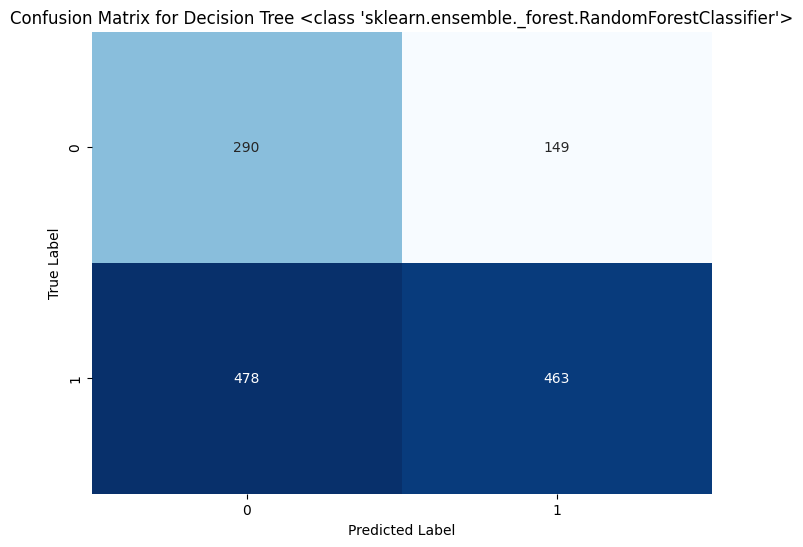

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model=fit_and_evaluate(re_Xtrain, y_train,re_Xtest , y_test,RandomForestClassifier(n_estimators=50, max_depth=9,max_leaf_nodes=6 ))


PCA+DT

Accuracy: 0.5833333333333334
Recall: 0.5833333333333334
Precision: 0.6000235918030168
F1-score: 0.5904135146559389
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.37      0.42      0.39       439
           1       0.71      0.66      0.68       941

    accuracy                           0.58      1380
   macro avg       0.54      0.54      0.54      1380
weighted avg       0.60      0.58      0.59      1380



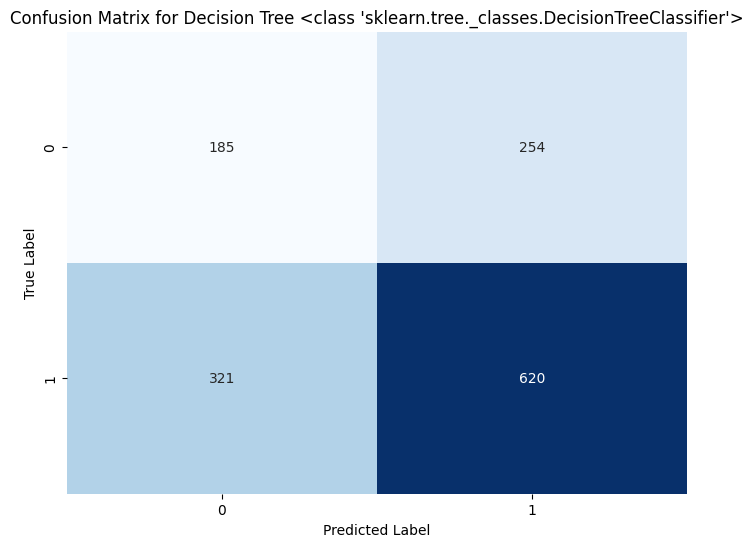

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
tree_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(**tree_params)
model=fit_and_evaluate(re_Xtrain, y_train,re_Xtest , y_test,dt_classifier)

PCA+KNN

Accuracy: 0.605072463768116
Recall: 0.605072463768116
Precision: 0.5700158031554561
F1-score: 0.5824105853749285
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.33      0.23      0.27       439
           1       0.68      0.78      0.73       941

    accuracy                           0.61      1380
   macro avg       0.50      0.50      0.50      1380
weighted avg       0.57      0.61      0.58      1380



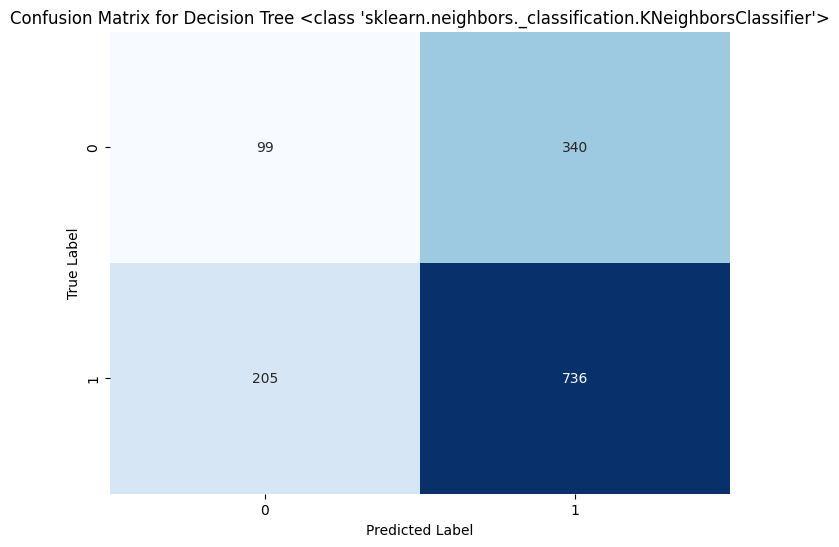

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model=fit_and_evaluate(re_Xtrain, y_train,re_Xtest , y_test,KNeighborsClassifier(algorithm='auto', n_neighbors=15, weights='uniform'))



PCA+XGBoost

Accuracy: 0.5978260869565217
Recall: 0.5978260869565217
Precision: 0.6658932960420375
F1-score: 0.6115558764162481
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.42      0.66      0.51       439
           1       0.78      0.57      0.66       941

    accuracy                           0.60      1380
   macro avg       0.60      0.61      0.58      1380
weighted avg       0.67      0.60      0.61      1380



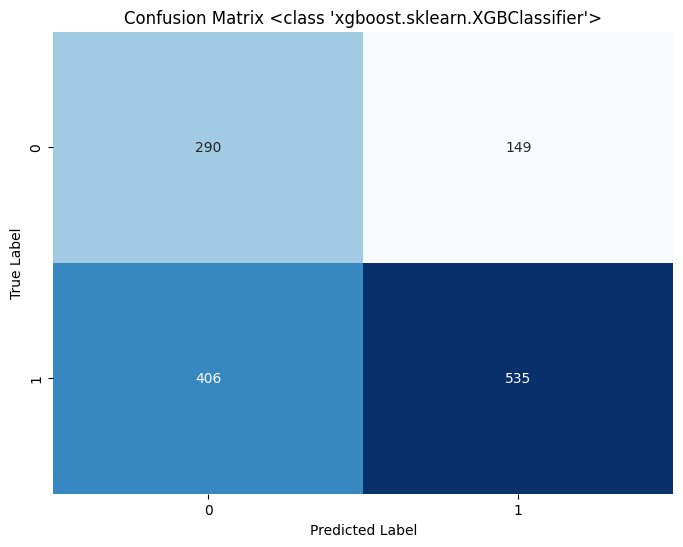

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Train a Decision Tree Classifier
xgb_classifier = XGBClassifier(
    max_depth=9,
    n_estimators=200,
    learning_rate=0.01
)
model=fit_and_evaluate(re_Xtrain, y_train,re_Xtest , y_test,xgb_classifier)


# CNN with DT

In [ ]:

from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP-Data/X_train_selected.npy')
X_val = np.load('/content/drive/MyDrive/GP-Data/X_validate_selected.npy')
X_test = np.load('/content/drive/MyDrive/GP-Data/X_test_selected.npy')
y_train = np.load('/content/drive/MyDrive/GP-Data/y_train.npy')
y_val = np.load('/content/drive/MyDrive/GP-Data/y_validate.npy')
y_test = np.load('/content/drive/MyDrive/GP-Data/y_test.npy')

print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)


(4728, 3) (1039, 3) (1383, 3) (4728, 1) (1039, 1) (1383, 1)


In [ ]:
train_percent = X_train.shape[0] / (X_train.shape[0] + X_val.shape[0] + X_test.shape[0]) * 100
validate_percent = X_val.shape[0] / (X_train.shape[0] + X_val.shape[0] + X_test.shape[0]) * 100
test_percent = X_test.shape[0] / (X_train.shape[0] + X_val.shape[0] + X_test.shape[0]) * 100

print(f"Train data: {train_percent:.2f}%")
print(f"Validation data: {validate_percent:.2f}%")
print(f"Test data: {test_percent:.2f}%")


Train data: 66.13%
Validation data: 14.53%
Test data: 19.34%


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

data_array = np.load('/content/drive/MyDrive/GP-Data/data_array.npy')
label_array = np.load('/content/drive/MyDrive/GP-Data/label_array.npy')
group_array = np.load('/content/drive/MyDrive/GP-Data/group_array.npy')

print(data_array.shape,label_array.shape,group_array.shape)

(7150, 1250, 33) (7150,) (7150,)


In [ ]:
gkf=GroupKFold()
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)


def three_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      train_features, train_label = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      train_features=scaler.fit_transform(train_features)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  # Split train_features into train and val
  for train_index, val_index in gkf.split(train_features, train_label, groups= train_groups):
      X_train, y_train =train_features[train_index],train_label[train_index]
      X_val, y_val =train_features[val_index],train_label[val_index]

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[val_index])}")

      break

  return X_train, X_val, X_test, y_train, y_val, y_test




def two_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      X_train, y_train = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      X_train=scaler.fit_transform(X_train)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  return X_train, X_test, y_train, y_test


X_train, X_val, X_test, y_train, y_val, y_test = three_splits(data_array , label_array, group_array)

#X_train, X_test, y_train, y_test = two_splits(data_array , label_array, group_array)

# convert the problem from multiclass classification to binary classification
# make haemorrhage and schaemia classes as one

y_train[y_train==0] = 1
y_train[y_train==2] = 0

y_val[y_val==0] = 1
y_val[y_val==2] = 0

y_test[y_test==0] = 1
y_test[y_test==2] = 0

group=[ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 18 19 20 22 23 25 27 28 29
 30 31 34 36 37 38 39 40 41 42 43 44 45 46 47]
group=[ 9 14 17 21 24 26 32 33 35]
group=[ 0  2  3  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38]
group=[ 1  4  8 15 16 22 23 27 28 35 36]


In [ ]:
# Flatten the data array for ML models
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

def select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val ,threshold=0.1):
    tree_params = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}
    # Train a Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(**tree_params)

    # Train a Decision Tree classifier to select important features
    #dt = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Select features based on importance using the trained Decision Tree
    # The threshold parameter is set to 0.00001, meaning that features with importance scores greater than or equal to
    #0.00001 will be considered important and selected, while features with importance scores lower than 0.00001 will be discarded.
    sfm = SelectFromModel(dt_classifier, threshold=0.01)
    sfm.fit(X_train, y_train)

    # Transform the training and testing data to include only the selected features
    X_train_selected = sfm.transform(X_train)
    X_test_selected = sfm.transform(X_test)
    X_val_selected = sfm.transform(X_val)

    print(X_train_selected)
    print(X_test_selected)
    print(X_val_selected)
    print("-------------------------")
    # Get indices of selected features
    selected_feature_indices = sfm.get_support(indices=True)

    # Get names of selected features
    selected_feature_names = [f"Feature {i+1}" for i in selected_feature_indices]

    # Print selected features
    print("Selected Features:")
    for feature in selected_feature_names:
        print(feature)


    return X_train_selected, X_test_selected, X_val_selected

In [ ]:
X_trainD, X_testD, X_valD = select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val)


[[-3.92122071 -3.90876296 -4.07543816 -4.20539541 -4.14186057]
 [-3.92122071 -3.90876296 -4.07543816 -4.20539541 -4.14186057]
 [-3.92122071 -3.90876296 -4.07543816  0.1878699   0.16929068]
 ...
 [-0.17531763 -0.17525365 -0.08673444 -0.15129016 -0.12309218]
 [-0.17531763 -0.17525365 -0.08673444 -0.15129016 -0.12309218]
 [-0.17531763 -0.17525365 -0.08673444 -0.15129016 -0.12309218]]
[[-1.47669020e-01 -1.20165967e-01 -8.46864627e-02 -8.46864627e-02
  -1.71030130e-01]
 [-1.47669020e-01 -1.20165967e-01 -8.46864627e-02 -8.46864627e-02
  -1.71030130e-01]
 [-1.47669020e-01 -1.20165967e-01 -8.46864627e-02 -8.46864627e-02
  -1.71030130e-01]
 ...
 [-8.61341994e-02 -1.22234380e-01 -3.20702906e-13 -1.50228465e-01
  -3.20702906e-13]
 [-8.61341994e-02 -1.22234380e-01 -3.20702906e-13 -1.50228465e-01
  -3.20702906e-13]
 [-8.61341994e-02 -1.22234380e-01 -3.20702906e-13 -1.50228465e-01
  -3.20702906e-13]]
[[-0.12266103 -0.12266103 -0.17463109 -0.12266103 -0.17469483]
 [-0.12266103 -0.12266103 -0.17463109

In [ ]:
print(X_trainD.shape)
print(X_testD.shape)
print(X_valD.shape)

(4728, 5)
(1383, 5)
(1039, 5)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

def block(input):
    conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input)
    conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input)
    conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input)
    x = concatenate([conv1, conv2, conv3], axis=2)
    return x

# Define the input layer
input_layer = Input(shape=(5, 1))

# Create the first block
block1 = block(input_layer)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

cnn_out1 = Conv1D(32, 3, activation='relu', padding='same')(block3)
cnn_out2 = Conv1D(32, 3, activation='relu', padding='same')(cnn_out1)
cnn_out3 = MaxPooling1D(pool_size=1)(cnn_out2)
cnn_out4 = Flatten()(cnn_out3)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(cnn_out4)

# Define the model with 'input_layer' as the input and 'predictions' as the output
model = Model(inputs=input_layer, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#X_trainD, X_testD, X_valD = select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val)
hist = model.fit(X_trainD, y_train, epochs=70, batch_size=64,
                     validation_data=(X_valD, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 4s 11ms/step - loss: 0.6912 - accuracy: 0.5931 - val_loss: 0.6899 - val_accuracy: 0.5756
Epoch 2/70
74/74 [==============================] - 0s 6ms/step - loss: 0.6857 - accuracy: 0.5939 - val_loss: 0.6845 - val_accuracy: 0.5775
Epoch 3/70
74/74 [==============================] - 0s 6ms/step - loss: 0.6766 - accuracy: 0.5935 - val_loss: 0.6776 - val_accuracy: 0.5775
Epoch 4/70
74/74 [==============================] - 1s 7ms/step - loss: 0.6620 - accuracy: 0.5929 - val_loss: 0.6684 - val_accuracy: 0.5765
Epoch 5/70
74/74 [==============================] - 0s 6ms/step - loss: 0.6344 - accuracy: 0.6392 - val_loss: 0.6548 - val_accuracy: 0.5794
Epoch 6/70
74/74 [==============================] - 0s 5ms/step - loss: 0.5972 - accuracy: 0.7225 - val_loss: 0.6443 - val_accuracy: 0.5804
Epoch 7/70
74/74 [==============================] - 0s 5ms/step - loss: 0.5617 - accuracy: 0.7396 - val_loss: 0.6442 - val_accuracy: 0.5861
Epoch 8/70
74/74 [=

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_testD)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 0s 2ms/step
Accuracy: 0.6623282718727405
Recall: 0.6529535864978903
Precision: 0.8177014531043593
F1-score: 0.7260997067448681


Average Confusion Matrix:
44/44 [==============================] - 0s 2ms/step


<Figure size 800x600 with 0 Axes>

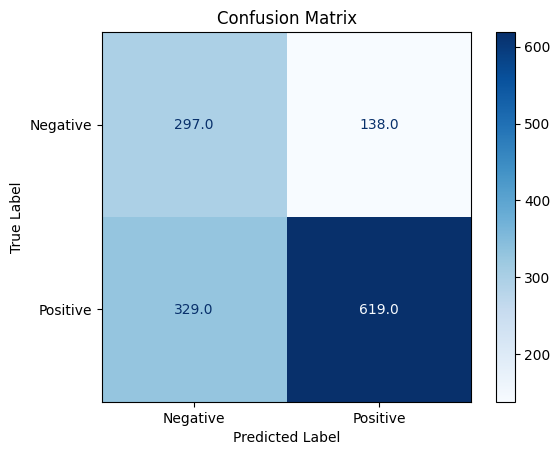

              precision    recall  f1-score   support

           0       0.47      0.68      0.56       435
           1       0.82      0.65      0.73       948

    accuracy                           0.66      1383
   macro avg       0.65      0.67      0.64      1383
weighted avg       0.71      0.66      0.67      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_testD)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

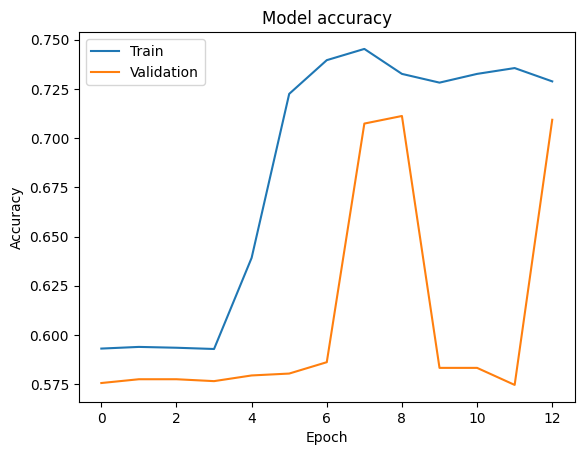

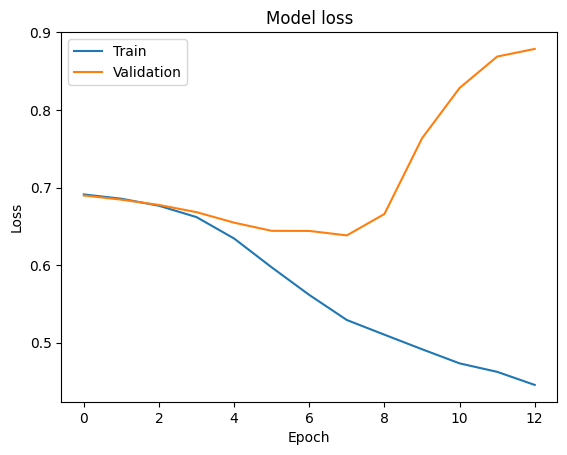

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# LSTM+DT

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

model = Sequential()
model.add(LSTM(units = 100, return_sequences = True, input_shape = (5, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(X_trainD, y_train, epochs=30, batch_size=128, validation_data=(X_valD, y_val), callbacks=[early_stopping])



Epoch 1/30
37/37 [==============================] - 5s 42ms/step - loss: 0.6778 - accuracy: 0.5899 - val_loss: 0.6813 - val_accuracy: 0.5775
Epoch 2/30
37/37 [==============================] - 1s 18ms/step - loss: 0.6766 - accuracy: 0.5935 - val_loss: 0.6839 - val_accuracy: 0.5775
Epoch 3/30
37/37 [==============================] - 1s 17ms/step - loss: 0.6595 - accuracy: 0.6138 - val_loss: 0.5778 - val_accuracy: 0.5794
Epoch 4/30
37/37 [==============================] - 1s 17ms/step - loss: 0.5498 - accuracy: 0.7316 - val_loss: 0.6772 - val_accuracy: 0.5804
Epoch 5/30
37/37 [==============================] - 1s 17ms/step - loss: 0.4811 - accuracy: 0.7692 - val_loss: 0.6474 - val_accuracy: 0.5794
Epoch 6/30
37/37 [==============================] - 1s 16ms/step - loss: 0.6022 - accuracy: 0.6622 - val_loss: 0.6453 - val_accuracy: 0.5775
Epoch 7/30
37/37 [==============================] - 1s 16ms/step - loss: 0.5298 - accuracy: 0.7392 - val_loss: 0.6839 - val_accuracy: 0.5727
Epoch 8/30
37

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_testD)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 1s 3ms/step
Accuracy: 0.586406362979031
Recall: 0.7120253164556962
Precision: 0.6930184804928131
F1-score: 0.7023933402705514


Average Confusion Matrix:
44/44 [==============================] - 0s 3ms/step


<Figure size 800x600 with 0 Axes>

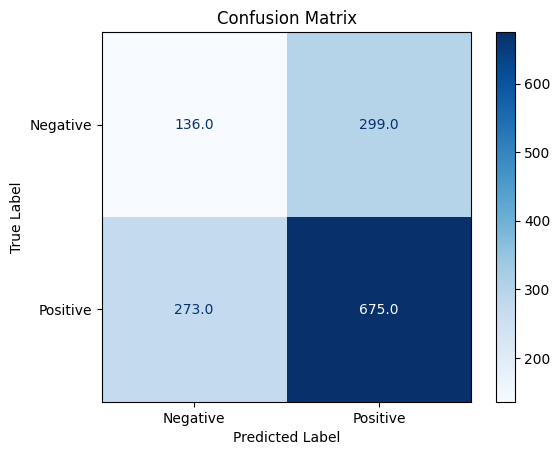

              precision    recall  f1-score   support

           0       0.33      0.31      0.32       435
           1       0.69      0.71      0.70       948

    accuracy                           0.59      1383
   macro avg       0.51      0.51      0.51      1383
weighted avg       0.58      0.59      0.58      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_testD)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

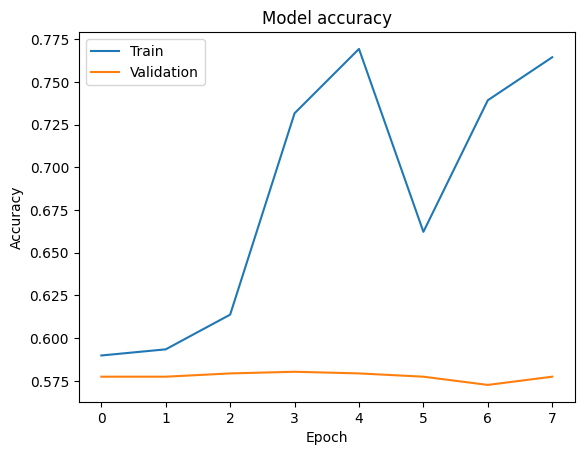

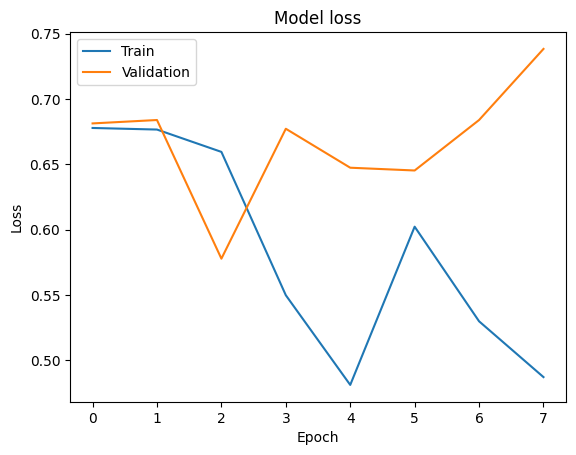

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# CNN+LSTM+DT

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define the input layer with a shape of (1250, 33)
input_layer = Input(shape=(5, 1))

# Convolutional Block
conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input_layer)
conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input_layer)
conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input_layer)
cnn_output = concatenate([conv1, conv2, conv3], axis=2)

# LSTM Layer
lstm_layer = LSTM(64)(cnn_output)

# Fully Connected Layers
dense1 = Dense(32, activation='tanh')(lstm_layer)

# Output Layer
predictions = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


hist = model.fit(X_trainD, y_train, epochs=70, batch_size=64, validation_data=(X_valD, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 4s 14ms/step - loss: 0.6784 - accuracy: 0.5888 - val_loss: 0.6825 - val_accuracy: 0.5707
Epoch 2/70
74/74 [==============================] - 0s 6ms/step - loss: 0.6512 - accuracy: 0.5905 - val_loss: 0.6583 - val_accuracy: 0.5756
Epoch 3/70
74/74 [==============================] - 0s 6ms/step - loss: 0.5655 - accuracy: 0.7430 - val_loss: 0.8444 - val_accuracy: 0.5775
Epoch 4/70
74/74 [==============================] - 0s 6ms/step - loss: 0.5023 - accuracy: 0.7891 - val_loss: 0.9006 - val_accuracy: 0.5775
Epoch 5/70
74/74 [==============================] - 0s 6ms/step - loss: 0.4067 - accuracy: 0.8185 - val_loss: 2.0625 - val_accuracy: 0.5813
Epoch 6/70
74/74 [==============================] - 0s 6ms/step - loss: 0.3077 - accuracy: 0.8604 - val_loss: 2.4335 - val_accuracy: 0.5823
Epoch 7/70
74/74 [==============================] - 1s 7ms/step - loss: 0.1953 - accuracy: 0.9078 - val_loss: 3.8297 - val_accuracy: 0.5813


In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_testD)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 1s 2ms/step
Accuracy: 0.7729573391178597
Recall: 0.9831223628691983
Precision: 0.7577235772357723
F1-score: 0.8558310376492195


Average Confusion Matrix:
44/44 [==============================] - 0s 2ms/step


<Figure size 800x600 with 0 Axes>

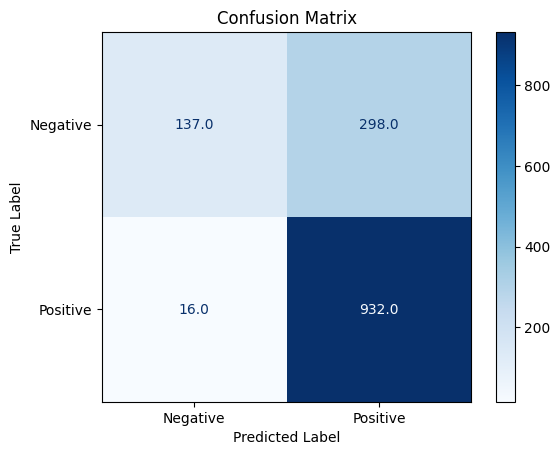

              precision    recall  f1-score   support

           0       0.90      0.31      0.47       435
           1       0.76      0.98      0.86       948

    accuracy                           0.77      1383
   macro avg       0.83      0.65      0.66      1383
weighted avg       0.80      0.77      0.73      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_testD)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

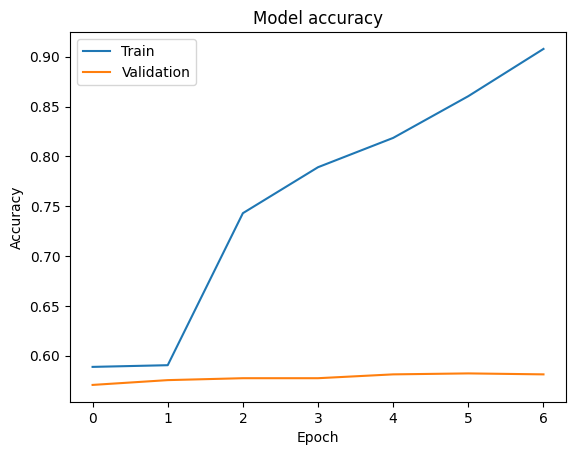

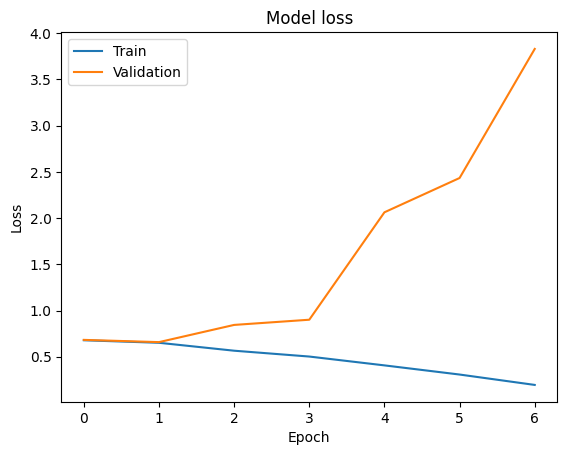

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# CNN+GRU+DT

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chrononet/chrono.py

def block(input):

  """
    Create a block consisting of three parallel convolutional layers followed by concatenation.

    Parameters:
    - input: Input tensor.

    Returns:
    - Concatenated tensor resulting from the parallel convolutional layers.
    """

  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

# Define the input layer with a shape of (1250, 33)
input = Input(shape=(5, 1))

# Create the first block
block1 = block(input)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(gru_out4)

# Define the model with 'input' as the input and 'predictions' as the output
model = Model(inputs=input, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(X_trainD, y_train, epochs=70, batch_size=64, validation_data=(X_valD, y_val), callbacks=[early_stopping])

Epoch 1/70
74/74 [==============================] - 11s 30ms/step - loss: 0.6390 - accuracy: 0.6345 - val_loss: 0.7980 - val_accuracy: 0.5794
Epoch 2/70
74/74 [==============================] - 1s 10ms/step - loss: 0.4666 - accuracy: 0.7733 - val_loss: 1.3578 - val_accuracy: 0.5852
Epoch 3/70
74/74 [==============================] - 1s 10ms/step - loss: 0.2489 - accuracy: 0.8839 - val_loss: 2.7404 - val_accuracy: 0.5813
Epoch 4/70
74/74 [==============================] - 1s 10ms/step - loss: 0.0714 - accuracy: 0.9710 - val_loss: 3.4462 - val_accuracy: 0.5804
Epoch 5/70
74/74 [==============================] - 1s 10ms/step - loss: 0.0487 - accuracy: 0.9759 - val_loss: 3.5815 - val_accuracy: 0.5775
Epoch 6/70
74/74 [==============================] - 1s 10ms/step - loss: 0.0439 - accuracy: 0.9748 - val_loss: 3.6795 - val_accuracy: 0.5813


In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_testD)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 2s 3ms/step
Accuracy: 0.6818510484454086
Recall: 0.6972573839662447
Precision: 0.812039312039312
F1-score: 0.7502837684449489


Average Confusion Matrix:
44/44 [==============================] - 0s 3ms/step


<Figure size 800x600 with 0 Axes>

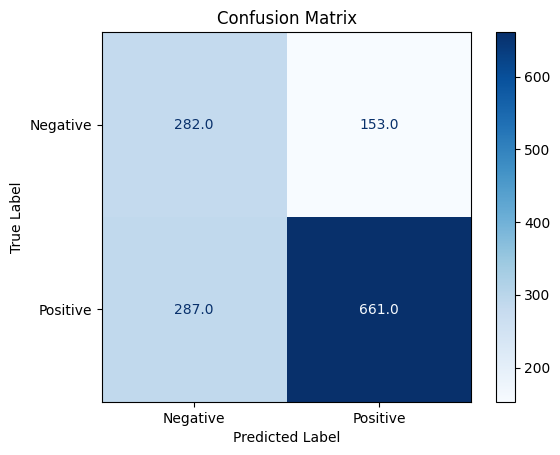

              precision    recall  f1-score   support

           0       0.50      0.65      0.56       435
           1       0.81      0.70      0.75       948

    accuracy                           0.68      1383
   macro avg       0.65      0.67      0.66      1383
weighted avg       0.71      0.68      0.69      1383



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_testD)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)

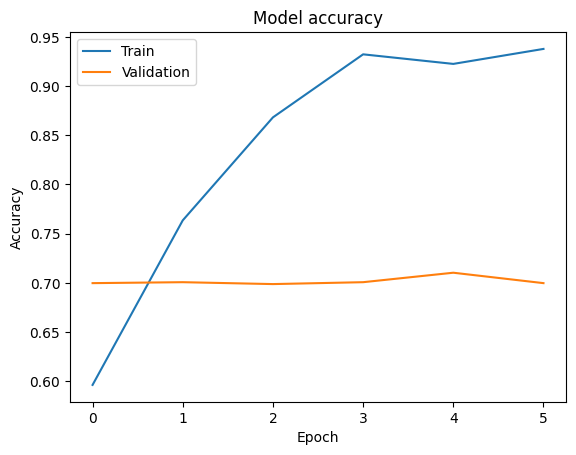

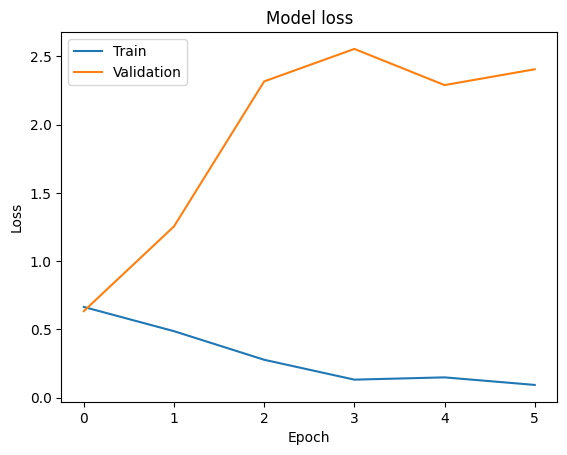

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
